# COVID-19 Detection in Chest X-Ray Images
The goal of this project is to build a model that identifies COVID-19, pneumonia in chest X-Ray images. The dataset is organized into 3 folders (COVID-19 cases, Normal , Pneumonia) and contains subfolders for each image category. There are 606 X-Ray images (JPEG). Data from [Mendeley](https://data.mendeley.com/datasets/fvk7h5dg2p/1). 

In [1]:
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import requests
from roboflow import Roboflow
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
load_dotenv()
roboflow_api_key = os.getenv("ROBOFLOW_API_KEY")

In [3]:
dataroot = "dataroot/"
zip_path = dataroot + "fvk7h5dg2p-1.zip"
raw_path = dataroot + "raw/"

def download_data(url):
    '''
    Creates a directory nammed 'dataroot' and downloads the zip file from the url and saves the zip file
    to the 'dataroot' folder.
    '''
    response = requests.get(url, params={"downloadformat": "zip"})
    if not os.path.isdir(dataroot):
        os.makedirs(dataroot)
        with open(zip_path, "wb") as file:
            file.write(response.content)


def unzip_data():
    if os.path.isdir(dataroot):
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            for file in zip_ref.namelist():
                sanitized_name = file.strip().replace("\\", "/") #Ensure consistent path format
                #Sanitize folder name for "Normal "
                if sanitized_name.startswith("Normal "):
                    sanitized_name = sanitized_name.replace("Normal ", "Normal", 1)
                if sanitized_name.startswith("COVID-19"):
                    sanitized_name = sanitized_name.replace("COVID-19 cases", "COVID-19", 1)
            
                #Create the full target path within the 'Normal' folder
                target_path = os.path.join(raw_path, sanitized_name)

                #Skip directories (avoid trying to open them as files)
                if file.endswith("/"):
                    os.makedirs(target_path, exist_ok=True)
                    continue
            
                #Ensure the parent directory exists before extracting
                os.makedirs(os.path.dirname(target_path), exist_ok=True)

                # Extract file safely
                with zip_ref.open(file) as source, open(target_path, "wb") as target:
                    target.write(source.read())

        os.remove(zip_path) # Remove zip file
        print("Extraction completed successfully.")

In [4]:
# Download and unzip
if not os.path.isdir(dataroot):
    download_data("https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip")
    unzip_data()
else:
    print("dataroot already exists.")

dataroot already exists.


cleaning with roboflow

In [ ]:
#Connecting to the model on roboflow
rf = Roboflow(api_key=roboflow_api_key)
project = rf.workspace().project("cap-project-u384k")
model = project.version(1).model

R0Fmr5AjCMpkbtaADUzd
loading Roboflow workspace...
loading Roboflow project...


In [10]:
def clean_x_rays(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for item in os.walk(input_folder):
        root = item[0]
        files = item[2]
        for file in files:
            img = cv.imread(os.path.join(root, file))
            result = model.predict(img, confidence=20, overlap=30).json()
            for i in range(len(result['predictions'])):
                prediction = result['predictions'][i]
                roi_x = int(prediction['x'] - prediction['width']/2)
                roi_y = int(prediction['y'] - prediction['height']/2)
                roi_width = int(prediction['width'])
                roi_height = int(prediction['height'])
                img[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width] = 0
            cv.imwrite(os.path.join(output_folder, file), img)


clean_path = dataroot + "cleaned/"
clean_x_rays(r"dataroot\COVID-19", clean_path + "COVID-19")
clean_x_rays(r"dataroot\Normal", clean_path + "Normal")
clean_x_rays(r"dataroot\Pneumonia", clean_path + "Pneumonia")

'''
img = cv2.imread("/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg")
result = model.predict(img, confidence=20, overlap=30).json()
for i in range(len(result['predictions'])):
    prediction = result['predictions'][i]
    roi_x = int(prediction['x'] - prediction['width']/2)
    roi_y = int(prediction['y'] - prediction['height']/2)
    roi_width = int(prediction['width'])
    roi_height = int(prediction['height'])
    img[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width] = 0

cv2_imshow(img)
black_mask = np.all(img == 0, axis=-1)
alpha = np.uint8(np.logical_not(black_mask)) * 255
bgra = np.dstack((img, alpha))
cv2_imshow(bgra)
'''

'\nimg = cv2.imread("/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg")\nresult = model.predict(img, confidence=20, overlap=30).json()\nfor i in range(len(result[\'predictions\'])):\n    prediction = result[\'predictions\'][i]\n    roi_x = int(prediction[\'x\'] - prediction[\'width\']/2)\n    roi_y = int(prediction[\'y\'] - prediction[\'height\']/2)\n    roi_width = int(prediction[\'width\'])\n    roi_height = int(prediction[\'height\'])\n    img[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width] = 0\n\ncv2_imshow(img)\nblack_mask = np.all(img == 0, axis=-1)\nalpha = np.uint8(np.logical_not(black_mask)) * 255\nbgra = np.dstack((img, alpha))\ncv2_imshow(bgra)\n'

TypeError: Image data of dtype object cannot be converted to float

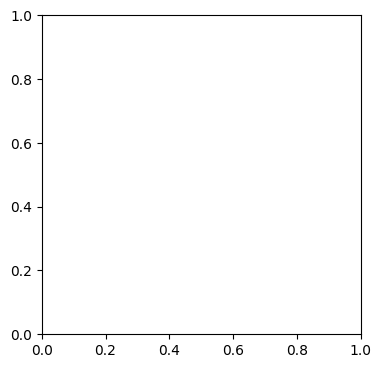

In [8]:
# Load and preview images
dataroot = "dataroot/"
img_covid     = cv.imread(dataroot+'COVID-19/1-s2.0-S0929664620300449-gr2_lrg-d.jpg',0)
img_normal    = cv.imread(dataroot+'Normal/IM-0011-0001-0001.jpeg',0)
img_pneumonia = cv.imread(dataroot+'Pneumonia/person11_virus_38.jpeg',0)

plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(img_covid,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img_normal,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(img_pneumonia,cmap='gray')

Functions for preprocessing the x-rays and then returning images and their labels for creating a df

In [ ]:
def preprocess_xray(img, resize_shape=(512, 512)):
    """
    Converts the image to grayscale if needed, resizes it, and normalizes pixel values.
    """
    
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        gray_img = img.copy()

    # Resize and normalize
    resized = cv.resize(gray_img, resize_shape)
    normalized = resized.astype(np.float32) / 255.0

    return normalized

def load_and_process_images(base_dir, resize_shape=(512, 512)):
    """
    Loads and preprocesses images from subdirectories in the given base directory.

    Args:
        base_dir (str): Path to the directory containing class subfolders.
        resize_shape (tuple): Desired image size (width, height) for resizing.

    Returns:
        tuple: Arrays of processed images and their corresponding labels.
    """

    images = []
    labels = []
    class_names = sorted(os.listdir(base_dir))

    for label_index, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            img = cv.imread(file_path)
            if img is not None:
                processed = preprocess_xray(img, resize_shape)
                images.append(processed)
                labels.append(class_name)

    return np.array(images), np.array(labels)

get images and labels, put flattened images and labels into a df, then split into training and test datasets

In [ ]:
images, labels = load_and_process_images(dataroot)

df = pd.DataFrame({
    "image": [img.flatten() for img in images],
    "label": labels
})

X_train, X_test, y_train, y_test = train_test_split(np.array(df["image"].tolist()), df["label"], test_size=0.2, stratify=labels, random_state=42)

random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state=42)

# Train the classifier
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")

Random Forest Accuracy: 0.85


In [ ]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [50, 100, 150, 200, 250]
}

grid_search = GridSearchCV(
    rf, 
    param_grid=param_grid,
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score:: {grid_search.best_score_}")

SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', random_state=42)

# Train the classifier
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")

Random Forest Accuracy: 0.89


k-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)   

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")

Random Forest Accuracy: 0.74


logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)

# Train the classifier
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")

Random Forest Accuracy: 0.88
